# AI Project - Phase 2 (Destination Suggestion)
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi, Javad Hezareh, Payam Taebi, Alireza Sakhaei, Ali Banayeean, Yalda Shabanzadeh, Hamidreza Yaghoubi, Alireza Heidari <h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase2.ipynb or .zip </h5>
</div>

## Overview

<div style="text-align: center">
<img src="./Images/Uber_research.jpg" width="100%" height="auto" />
</div>

Suppose you are a research engineer at Uber and you are asked to design a system that suggests destinations to the passengers. The system should be able to suggest destinations based on the passenger's history. For example, one passenger may save a variety of locations (like home, work, gym, etc.). This passenger may go to gym, often on weekends and when he/she requests a car from Home.

So, for example, if I am a student, going to university usually from Saturday to Wednesday on 8:00 from "home", the next time I request a car from "home" on 8:00, the system should suggest "university" as the destination. Now, it's not that simple always, so we should seek for smart wayys to solve this problem!

As you may understood by now, we should engineer some of features from the data we have and try to predict the next destination of the passenger.

Let's begin!

## Setup

In [ ]:
%pip install pyrosm keplergl haversine pandas numpy

In [ ]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
from copy import deepcopy
from tqdm import tqdm


from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [1]:
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

random.seed(2024)
np.random.seed(2024)

# First Approach: Using KNN

## Data Preparation for KNN

In this part, you should prepare the data for KNN. You should load the dataset file that we provided, named `Data/output.json` and then clean it, do all the required preprocessings and then split into train-test-val sets if necessary. Note that we provided a splitted test set for you, named `Data/output_test.json`. You should not use this file for training or validation. You should only use it for testing your model.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# TODO: Load the dataset for training
train_df = pd.read_json('/content/drive/My Drive/AI/project/AI_Project_main_Phase2/Data/output.json')
train_df.head()

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
0,0,0,35.625,51.375,36.000,51.085,2024-01-30 13:07:00,2024-01-30 14:43:00,43.99
1,0,0,36.000,51.085,35.625,51.375,2024-01-30 15:13:00,2024-01-30 16:49:00,36.66
2,0,0,35.680,51.445,35.745,51.465,2024-01-30 20:41:00,2024-01-30 20:54:00,15.08
3,0,0,35.745,51.465,35.680,51.445,2024-01-30 21:24:00,2024-01-30 21:37:00,10.00
4,0,1,35.625,51.375,35.680,51.445,2024-01-30 23:38:00,2024-01-30 23:58:00,19.48


In [4]:
# TODO: Load the dataset for testing
test_df = pd.read_json('/content/drive/My Drive/AI/project/AI_Project_main_Phase2/Data/output_test.json')
test_df.head()

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
0,24,6,35.650,51.225,35.640,51.270,2024-01-30 11:58:00,2024-01-30 12:12:00,10.00
1,46,2,35.625,51.250,35.690,51.295,2024-01-30 21:58:00,2024-01-30 22:18:00,11.84
2,27,5,35.650,51.225,35.865,51.045,2024-01-30 20:05:00,2024-01-30 20:58:00,23.36
3,7,4,35.875,51.375,35.890,51.315,2024-01-30 17:39:00,2024-01-30 18:17:00,13.74
4,27,3,35.625,51.375,35.650,51.385,2024-01-30 13:16:00,2024-01-30 13:19:00,15.08


In [5]:
# print out the number of unique users and also randomly select one user
num_users = train_df['user_id'].unique().shape[0]
user = random.choice(train_df['user_id'])
num_users, user

(60, 52)

In [6]:
# Uncomment the following line if you are using Google Colab
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
selected_df = train_df[train_df['user_id'] == user][['dest lat', 'dest lon']]

In [ ]:
# choose the data related to the randomly selected user
# show destinations of this user on map
# You should Use Kepler.gl to visualize the data

selected_map = KeplerGl(height=600, width=800)

selected_map.add_data(data=selected_df, name='selected_map')

selected_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'selected_map': {'index': [9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 98…

Here, you should do feature engineering stuff! Extract the features that you think are important. Split the features into training set and also extract the related outputs (used for our model further). These outputs may be strings (name of destination) or destination's latitude/longitude or etc. Use your creativity!

In [ ]:
train_df.shape, test_df.shape

((17994, 9), (4499, 9))

We use the trip time (in minutes) as a training feature.

In [ ]:
train_df['trip_time'] = train_df['end_time'] - train_df['start_time']
test_df['trip_time'] = test_df['end_time'] - test_df['start_time']

train_df['trip_time'] = train_df['trip_time'].apply(datetime.timedelta.total_seconds) / 60
test_df['trip_time'] = test_df['trip_time'].apply(datetime.timedelta.total_seconds) / 60

In [ ]:
train_df.head()

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price,trip_time
0,0,0,35.625,51.375,36.000,51.085,2024-01-29 13:07:00,2024-01-29 14:43:00,43.99,96.0
1,0,0,36.000,51.085,35.625,51.375,2024-01-29 15:13:00,2024-01-29 16:49:00,36.66,96.0
2,0,0,35.680,51.445,35.745,51.465,2024-01-29 20:41:00,2024-01-29 20:54:00,15.08,13.0
3,0,0,35.745,51.465,35.680,51.445,2024-01-29 21:24:00,2024-01-29 21:37:00,10.00,13.0
4,0,1,35.625,51.375,35.680,51.445,2024-01-29 23:38:00,2024-01-29 23:58:00,19.48,20.0


In [ ]:
training_features = [col for col in train_df.columns if col not in ['dest lat', 'dest lon','start_time'	,'end_time']]

y_train = train_df[['dest lat', 'dest lon']]
x_train = train_df[training_features]

y_test = test_df[['dest lat', 'dest lon']]
x_test = test_df[training_features]

In [ ]:
# print out the shape of the train and test dataframes
print('(',x_train.shape,',',y_train.shape,'), (',x_test.shape,',',x_test.shape,')')

( (17994, 6) , (17994, 2) ), ( (4499, 6) , (4499, 6) )


## KNN Model

In this section, we are going to implement our KNN model. For further information on how KNN works, please refer to [this](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) link. As you can see, it's a simple algorithm. We will start with this and see the results of our _destination suggestion_ system.

In [ ]:
# Define the model
# TODO: You can change the signature of functions and also add any function you need
from collections import Counter

class NearestNeighbor():
    def __init__(self ,k=5):
        self.train_X = None
        self.train_y = None
        self.tolerance = 1e-4
        self.k = k

    def fit(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y

    def predict(self, x: pd.DataFrame):
        # Calculate distances between x and all examples in the training set
        distances = np.sqrt(np.sum(np.square(self.train_X - x), axis=1))

        # Find indices of the k nearest examples
        nearest_indices = np.argsort(distances)[:self.k].values

        pairs = [(self.train_y.iloc[nearest_indices]['dest lat'].iloc[i],self.train_y.iloc[nearest_indices]['dest lon'].iloc[i]) for i in range(self.train_y.iloc[nearest_indices].shape[0])]
        pair_counter = Counter(pairs)
        most_common_pair, frequency = pair_counter.most_common(1)[0]
        most_common_pair_index = pairs.index(most_common_pair)

        return most_common_pair

    def check_prediction(self, pred, truth):
      if (np.abs(pred[0] - truth['dest lat']) < self.tolerance) and  (np.abs(pred[1] - truth['dest lon']) < self.tolerance):
        return 1
      else :
        return 0

    def calculate_accuracy(self, x_df, target_df):
        summ = 0
        for col in range(x_df.shape[0]):
          summ += self.check_prediction(self.predict(x_df.iloc[col]), target_df.iloc[col])

        return summ/ x_df.shape[0]

for $k=1$ :

In [ ]:
NN_model = NearestNeighbor(k=1)
# Fit the model on training data
NN_model.fit(x_train,y_train)

In [ ]:
NN_model.predict(x_train.iloc[10])

(35.68, 51.445)

In [ ]:
y_train.iloc[10]

dest lat    35.680
dest lon    51.445
Name: 10, dtype: float64

In [ ]:
# Calculate the accuracy on training data
NN_model.calculate_accuracy(x_train,y_train)

0.9981660553517839

In [ ]:
# Calculate the accuracy on test data
NN_model.calculate_accuracy(x_test,y_test)

0.2482773949766615

for $k=3$ :

In [ ]:
NN_model3 = NearestNeighbor(k=3)
NN_model3.fit(x_train,y_train)

In [ ]:
NN_model3.calculate_accuracy(x_train,y_train)

0.8890185617428031

In [ ]:
NN_model3.calculate_accuracy(x_test,y_test)

0.2576128028450767

for $k=5$ :

In [ ]:
NN_model5 = NearestNeighbor(k=5)
NN_model5.fit(x_train,y_train)

In [ ]:
NN_model5.calculate_accuracy(x_train,y_train)

0.7033455596309881

In [ ]:
NN_model5.calculate_accuracy(x_test,y_test)

0.2665036674816626

for $k=7$ :

In [ ]:
NN_model7 = NearestNeighbor(k=7)
NN_model7.fit(x_train,y_train)

In [ ]:
NN_model7.calculate_accuracy(x_train,y_train)

0.5845281760586862

In [ ]:
NN_model7.calculate_accuracy(x_test,y_test)

0.26983774172038233

**QUESTION**: What do you think about this approach? Is it a good idea to use KNN for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

**Your Answer**:

As can be seen, this architecture is unable to accurately estimate the underlying patterns of the dataset, resulting in low accuracy on the test dataset. To improve this, we should consider using more complex models to reduce generalization error and enhance classification accuracy. Additionally, the increase in $k$ results in an increase in the bias of the model and a decrease in its variance, indicating that the model behaves less greedily, which can be interpreted as a reduction in overfitting. also pick a very large $k$, resulting in low accuracy on the test dataset.


<div style="text-align: center">
<img src="./Images/knn.png" width="50%" height="auto" />
</div>

<div style="text-align: center">
<img src="./Images/knn2.png" width="50%" height="auto" />
</div>

# Second Approach: Using XGBoost

In this part, we are going to use XGBoost to predict the next destination of the passenger. You can use `xgboost` library to implement this model. To learn more about XGBoost, please refer to [this](https://en.wikipedia.org/wiki/XGBoost) link. It should be familiar to you, as you saw decision trees in the class.

For this part, you can use the same data (that you did all the processes on) from the previous part. Or, if you need, you can reload the dataset and do new preprocessings on it.

You can see the overview of how XGBoost works in the image below:

<dev style="text-align: center">
<img src="./Images/XGBoost.png" />
</dev>

Although, this is for more information and you **do not** need to implement `XGBoost` from scratch. You can use the library that we mentioned above.

In [ ]:
%pip install xgboost

In [ ]:
import xgboost as xgb

# Defining the model
# TODO: You can change the signature of functions and also add any function you need

class Encoder():
    def __init__(self):
        self.labels_tabel = None
        self.inverse_tabel = None
        self.num_classes = None

    def fit(self, y):
        pairs = []
        for i in range(train_df.shape[0]):
          pairs.append((train_df.iloc[i]['origin lat'], train_df.iloc[i]['origin lon']))
          pairs.append((train_df.iloc[i]['dest lat'], train_df.iloc[i]['dest lon']))

        unique_pairs = set(pairs)
        labels_dict = dict()
        labels_dict_inverse = dict()
        for index,pair in enumerate(unique_pairs):
          labels_dict[pair] = index
          labels_dict_inverse[index] = pair

        self.labels_tabel = labels_dict
        self.inverse_tabel = labels_dict_inverse
        self.num_classes = len(unique_pairs)

    def transform(self, y):
        return self.labels_tabel[y]

    def inverse_transform(self, enc):
        return self.inverse_tabel[enc]

    def encode_df(self, y_df):
      out = []
      for i in range(y_df.shape[0]):
        out.append(self.transform((y_df.iloc[i]['dest lat'],y_df.iloc[i]['dest lon'])))

      return out

In [ ]:
encoder = Encoder()
encoder.fit(y_train)

In [ ]:
encoded_y_train = encoder.encode_df(y_train)
encoded_y_test = encoder.encode_df(y_test)

In [ ]:
print('orginal format of targets: ')
for i in range(5):
  print(f"({y_train.iloc[i]['dest lat']},{y_train.iloc[i]['dest lon']})", end = ' , ')

print('\n\ntransformed targets: ')
for i in range(5):
  print(f"({encoder.transform((y_train.iloc[i]['dest lat'],y_train.iloc[i]['dest lon']))})", end = ' , ')


print('\n\ninverse transformed targets: ')
for i in range(5):
  print(f"{encoder.inverse_transform(encoded_y_train[i])}", end = ' , ')


orginal format of targets: 
(36.0,51.085) , (35.625,51.375) , (35.745,51.465) , (35.68,51.445) , (35.68,51.445) , 

transformed targets: 
(21) , (108) , (23) , (31) , (31) , 

inverse transformed targets: 
(36.0, 51.085) , (35.625, 51.375) , (35.745, 51.465) , (35.68, 51.445) , (35.68, 51.445) , 

## Define and train `xgboost` classifier

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(objective='multi:softmax', num_class=encoder.num_classes)
model.fit(x_train, encoded_y_train)

# Make predictions
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

accuracy_train = accuracy_score(encoded_y_train, y_pred_train)
accuracy = accuracy_score(encoded_y_test, y_pred)

print("Training Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 99.39%
Test Accuracy: 65.10%


**QUESTION**: What do you think about this approach? Is it a good idea to use XGBoost for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

The `xgboost` model uses the boosting method, which involves learning multiple weak models and improving the classification performance hierarchically, to predict and model more complex patterns in the dataset. As observed, XGBoost outperforms KNN on the test dataset, demonstrating its ability to better estimate the underlying patterns of the dataset compared to KNN. It is evident that as the patterns in our dataset (related to passengers' history) become more complex, the KNN model struggles to classify the test dataset accurately. 


<dev style="text-align: center">
<img src="./Images/boosting.png" />
</dev>

**Question**: Please explain the problem of overfitting in XGBoost. How can you solve it? Provide a brief explanation.

**Your Answer:**

 ]n XGBoost model, Overfitting occurs when the model learns to fit the training data too well, capturing the **noise** rather than the underlying patterns. This can lead to poor generalization on new data, resulting in decreased predictive accuracy. 

We can employ below ways to mitigate overfitting in XGBoost:

1. Regularization Parameters (terms): Tuning the regularization parameters, like the learning rate, max depth, and min_child_weight, can help control the complexity of the model and prevent overfitting.
2. Early Stopping : By monitoring the model's performance on a separate validation dataset, you can stop training when the performance no longer improves, thus preventing overfitting.
3. Feature Selection : Consider using feature selection techniques (e.g. fisher method) to reduce the complexity of the model by excluding less important features, which can help mitigate overfitting.
4. Kfold Cross-Validation : Use techniques such as k-fold cross-validation to assess model performance on multiple subsets of the training data, helping to evaluate the model's generalization ability and identify overfitting.


# Third Approach: Classifier Using Neural Networks

In this approach, we are going to use a classifier using neural networks. You can think of this approach and how to model the problem as a classification problem in many ways! So, we are not going to restrict your creativity. Just a hint: You can consider each of the unique destinations (in whole dataset) as a class and then train a classifier to classify the destinations.

## Data for Neural Network

Let's prepare the data for our neural network. Again, you should extract required features from the dataset and then split the dataset into train-test-val sets if necessary. For your ease, we prepared another version of `output.json` that helps you to extract features for this part, easier. So, please load `Data/trip_data.json` and use it for training set and validation set. You should use `Data/trip_data_test.json` for testing your model.

In [72]:
# load the training dataset
train_df = pd.read_json('/content/drive/My Drive/AI/project/AI_Project_main_Phase2/Data/trip_data.json')
train_df.head()

,user_id,Day,origin,destination,start_time,end_time,price
0,0,0,"[work, [35.625, 51.375]]","[restaurant, [36.0, 51.085]]",2024-01-30 13:07:00,2024-01-30 14:43:00,43.99
1,0,0,"[restaurant, [36.0, 51.085]]","[work, [35.625, 51.375]]",2024-01-30 15:13:00,2024-01-30 16:49:00,36.66
2,0,0,"[home, [35.68, 51.445]]","[restaurant, [35.745, 51.465]]",2024-01-30 20:41:00,2024-01-30 20:54:00,15.08
3,0,0,"[restaurant, [35.745, 51.465]]","[home, [35.68, 51.445]]",2024-01-30 21:24:00,2024-01-30 21:37:00,10.00
4,0,1,"[work, [35.625, 51.375]]","[home, [35.68, 51.445]]",2024-01-30 23:38:00,2024-01-30 23:58:00,19.48


In [73]:
# load the test dataset
test_df = pd.read_json('/content/drive/My Drive/AI/project/AI_Project_main_Phase2/Data/trip_data_test.json')
test_df.head()

,user_id,Day,origin,destination,start_time,end_time,price
0,24,6,"[pool, [35.65, 51.225]]","[home, [35.64, 51.27]]",2024-01-30 11:58:00,2024-01-30 12:12:00,10.00
1,46,2,"[university, [35.625, 51.25]]","[restaurant, [35.69, 51.295]]",2024-01-30 21:58:00,2024-01-30 22:18:00,11.84
2,27,5,"[pool, [35.65, 51.225]]","[restaurant, [35.865, 51.045]]",2024-01-30 20:05:00,2024-01-30 20:58:00,23.36
3,7,4,"[work, [35.875, 51.375]]","[home, [35.89, 51.315]]",2024-01-30 17:39:00,2024-01-30 18:17:00,13.74
4,27,3,"[work, [35.625, 51.375]]","[restaurant, [35.65, 51.385]]",2024-01-30 13:16:00,2024-01-30 13:19:00,15.08


In [74]:
# Extract features and do preprocessing if needed

train_df['Origin Lat'] = train_df['origin'].apply(lambda x: x[-1][0])
train_df['Origin Lon'] = train_df['origin'].apply(lambda x: x[-1][1])
train_df['origin'] = train_df['origin'].apply(lambda x: x[0])

train_df['Dest Lat'] = train_df['destination'].apply(lambda x: x[-1][0])
train_df['Dest Lon'] = train_df['destination'].apply(lambda x: x[-1][1])
train_df['destination'] = train_df['destination'].apply(lambda x: x[0])

train_df['start_time'] = train_df['start_time'].apply(lambda x: x.time())
train_df['end_time'] = train_df['end_time'].apply(lambda x: x.time())

train_df.head()

,user_id,Day,origin,destination,start_time,end_time,price,Origin Lat,Origin Lon,Dest Lat,Dest Lon
0,0,0,work,restaurant,13:07:00,14:43:00,43.99,35.625,51.375,36.000,51.085
1,0,0,restaurant,work,15:13:00,16:49:00,36.66,36.000,51.085,35.625,51.375
2,0,0,home,restaurant,20:41:00,20:54:00,15.08,35.680,51.445,35.745,51.465
3,0,0,restaurant,home,21:24:00,21:37:00,10.00,35.745,51.465,35.680,51.445
4,0,1,work,home,23:38:00,23:58:00,19.48,35.625,51.375,35.680,51.445


In [75]:
# Extract features and do preprocessing if needed

test_df['Origin Lat'] = test_df['origin'].apply(lambda x: x[-1][0])
test_df['Origin Lon'] = test_df['origin'].apply(lambda x: x[-1][1])
test_df['origin'] = test_df['origin'].apply(lambda x: x[0])

test_df['Dest Lat'] = test_df['destination'].apply(lambda x: x[-1][0])
test_df['Dest Lon'] = test_df['destination'].apply(lambda x: x[-1][1])
test_df['destination'] = test_df['destination'].apply(lambda x: x[0])

test_df['start_time'] = test_df['start_time'].apply(lambda x: x.time())
test_df['end_time'] = test_df['end_time'].apply(lambda x: x.time())

test_df.head()

,user_id,Day,origin,destination,start_time,end_time,price,Origin Lat,Origin Lon,Dest Lat,Dest Lon
0,24,6,pool,home,11:58:00,12:12:00,10.00,35.650,51.225,35.640,51.270
1,46,2,university,restaurant,21:58:00,22:18:00,11.84,35.625,51.250,35.690,51.295
2,27,5,pool,restaurant,20:05:00,20:58:00,23.36,35.650,51.225,35.865,51.045
3,7,4,work,home,17:39:00,18:17:00,13.74,35.875,51.375,35.890,51.315
4,27,3,work,restaurant,13:16:00,13:19:00,15.08,35.625,51.375,35.650,51.385


In [76]:
for col in train_df.columns:
  unique_values = train_df[col].unique()
  print(f'\nColumn: {col}')
  print(f'Unique values:')
  for i in unique_values:
    print(i, end=', ')
  print()
  print('='*20)


Column: user_id
Unique values:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 

Column: Day
Unique values:
0, 1, 2, 3, 4, 6, 5, 

Column: origin
Unique values:
work, restaurant, home, park, university, gym, pool, 

Column: destination
Unique values:
restaurant, work, home, park, university, gym, pool, 

Column: start_time
Unique values:
13:07:00, 15:13:00, 20:41:00, 21:24:00, 23:38:00, 07:59:00, 21:19:00, 07:55:00, 14:11:00, 20:08:00, 21:03:00, 07:00:00, 13:50:00, 14:23:00, 21:40:00, 22:28:00, 20:28:00, 22:01:00, 12:05:00, 12:54:00, 17:29:00, 13:44:00, 14:59:00, 17:36:00, 07:49:00, 20:40:00, 22:21:00, 17:33:00, 21:51:00, 07:54:00, 13:35:00, 16:30:00, 22:35:00, 08:19:00, 11:24:00, 08:56:00, 12:17:00, 07:06:00, 07:42:00, 13:15:00, 13:53:00, 21:20:00, 07:51:00, 12:37:00, 13:40:00, 17:32:00, 20:46:00, 21:38:0

In [77]:
print('DataFrame Column Head and Data Type:')
print('========================================')

for col in train_df.columns:

  print(f'Column: {col}')
  print(f'Data Type: {train_df[col].dtype}')
  print('-'*20)

DataFrame Column Head and Data Type:
Column: user_id
Data Type: int64
--------------------
Column: Day
Data Type: int64
--------------------
Column: origin
Data Type: object
--------------------
Column: destination
Data Type: object
--------------------
Column: start_time
Data Type: object
--------------------
Column: end_time
Data Type: object
--------------------
Column: price
Data Type: float64
--------------------
Column: Origin Lat
Data Type: float64
--------------------
Column: Origin Lon
Data Type: float64
--------------------
Column: Dest Lat
Data Type: float64
--------------------
Column: Dest Lon
Data Type: float64
--------------------


Based on your features and how you extracted them, you may need to use some encodings for your data. For example, if you have different classes as names (`str` data type. E.g. "gym") you need to make it a numeric value in order to feed it into your neural network. You can use `sklearn`'s functions (such as `LabelEncoder`, `OneHotEncoder`, `StandardScaler`, etc.) to do these kind of stuff!

In [78]:
train_df.head()

,user_id,Day,origin,destination,start_time,end_time,price,Origin Lat,Origin Lon,Dest Lat,Dest Lon
0,0,0,work,restaurant,13:07:00,14:43:00,43.99,35.625,51.375,36.000,51.085
1,0,0,restaurant,work,15:13:00,16:49:00,36.66,36.000,51.085,35.625,51.375
2,0,0,home,restaurant,20:41:00,20:54:00,15.08,35.680,51.445,35.745,51.465
3,0,0,restaurant,home,21:24:00,21:37:00,10.00,35.745,51.465,35.680,51.445
4,0,1,work,home,23:38:00,23:58:00,19.48,35.625,51.375,35.680,51.445


In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [80]:
time_encoder = LabelEncoder()
lat_scaler = StandardScaler()
lon_scaler = StandardScaler()
price_scaler = StandardScaler()
# user_id_encoder = OneHotEncoder()
# Day_encoder = OneHotEncoder()
place_encoder = LabelEncoder()
time_scaler = StandardScaler()



# Fit the data to encode labels
time_encoder.fit(train_df[['start_time', 'end_time']].values.flatten())
place_encoder.fit(train_df[['origin',	'destination']].values.flatten())
lat_scaler.fit(train_df[['Origin Lat','Dest Lat']].values.flatten().reshape(-1, 1))
lon_scaler.fit(train_df[['Origin Lon','Dest Lon']].values.flatten().reshape(-1, 1))
price_scaler.fit(train_df['price'].values.reshape(-1, 1))


# encoded_user_id = user_id_encoder.fit_transform(train_df['user_id'])
# encoded_Day = Day_encoder.fit_transform(train_df['Day'])
train_df['origin'] = place_encoder.transform(train_df['origin'])
train_df['destination'] = place_encoder.transform(train_df['destination'])
train_df['price'] = price_scaler.transform(train_df['price'].values.reshape(-1, 1))
train_df['Origin Lat'] = lat_scaler.transform(train_df['Origin Lat'].values.reshape(-1, 1))
train_df['Dest Lat'] = lat_scaler.transform(train_df['Dest Lat'].values.reshape(-1, 1))
train_df['Origin Lon'] = lon_scaler.transform(train_df['Origin Lon'].values.reshape(-1, 1))
train_df['Dest Lon'] = lon_scaler.transform(train_df['Dest Lon'].values.reshape(-1, 1))

train_df['start_time'] = time_encoder.transform(train_df['start_time'])
train_df['end_time'] = time_encoder.transform(train_df['end_time'])

time_scaler.fit(train_df[['start_time', 'end_time']].values.flatten().reshape(-1, 1))
train_df['start_time'] = time_scaler.transform(train_df['start_time'].values.reshape(-1, 1))
train_df['end_time'] = time_scaler.transform(train_df['end_time'].values.reshape(-1, 1))

In [81]:
train_df.head()

,user_id,Day,origin,destination,start_time,end_time,price,Origin Lat,Origin Lon,Dest Lat,Dest Lon
0,0,0,6,4,-0.344335,-0.030587,2.614974,-0.873240,0.978733,1.742411,-1.298592
1,0,0,4,6,0.067460,0.381208,1.793070,1.742411,-1.298592,-0.873240,0.978733
2,0,0,1,4,1.139433,1.181920,-0.626668,-0.489612,1.528432,-0.036232,1.685489
3,0,0,4,1,1.279966,1.322453,-1.196282,-0.036232,1.685489,-0.489612,1.528432
4,0,1,6,1,1.717906,1.783270,-0.133301,-0.873240,0.978733,-0.489612,1.528432


On the test dataset :

In [105]:
test_df['origin'] = place_encoder.transform(test_df['origin'])
test_df['destination'] = place_encoder.transform(test_df['destination'])
test_df['price'] = price_scaler.transform(test_df['price'].values.reshape(-1, 1))
test_df['Origin Lat'] = lat_scaler.transform(test_df['Origin Lat'].values.reshape(-1, 1))
test_df['Dest Lat'] = lat_scaler.transform(test_df['Dest Lat'].values.reshape(-1, 1))
test_df['Origin Lon'] = lon_scaler.transform(test_df['Origin Lon'].values.reshape(-1, 1))
test_df['Dest Lon'] = lon_scaler.transform(test_df['Dest Lon'].values.reshape(-1, 1))

test_df['start_time'] = time_encoder.transform(test_df['start_time'])
test_df['end_time'] = time_encoder.transform(test_df['end_time'])

test_df['start_time'] = time_scaler.transform(test_df['start_time'].values.reshape(-1, 1))
test_df['end_time'] = time_scaler.transform(test_df['end_time'].values.reshape(-1, 1))

In [106]:
test_df.head()

,user_id,Day,origin,destination,start_time,end_time,price,Origin Lat,Origin Lon,Dest Lat,Dest Lon
0,24,6,3,1,-0.569841,-0.524086,-1.196282,-0.698864,-0.199194,-0.768614,0.154184
1,46,2,5,4,1.391085,1.456449,-0.989965,-0.873240,-0.002873,-0.419861,0.350505
2,27,5,3,4,1.021777,1.194992,0.301758,-0.698864,-0.199194,0.800776,-1.612706
3,7,4,6,1,0.544618,0.668810,-0.776920,0.870527,0.978733,0.975153,0.507562
4,27,3,6,4,-0.314921,-0.305116,-0.626668,-0.873240,0.978733,-0.698864,1.057262


Create `train_dataset` and its loader, also create `test_dataset` and its loader. You should also create `val_dataset` and its loader if you want to use validation set. You may need to implement a custom `torch.Dataset` class for your ease. Your loaders should be able to load data in batches.

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [83]:
class MyDataset(Dataset):
    def __init__(self, df):
        y = df['destination']
        x = df.drop('destination',axis=1)
        self.X = torch.tensor(x.values)
        self.y = torch.tensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [107]:
dataset_size = train_df.shape[0]
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # Remaining 20% for validation

my_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)

train_dataset, val_dataset = random_split(my_dataset, [train_size, test_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Neural Network Model

Here, you should implement your neural network model. You should use `pytorch`. **Note** that you should plot the loss function of your model during the training phase. (on both training and validation sets)

In [108]:
number_of_unique_destinations = 7
learning_rate = 1e-3

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

# Implement the train_model function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):

  for epoch in range(epochs):

      train_epoch_loss = 0.0
      val_epoch_loss = 0.0
      train_accuracies = []
      val_accuracies = []

      model.train()
      for (data, targets) in train_loader:
          data = data.to(device).float()
          targets = targets.to(device)#.float()

          optimizer.zero_grad()
          outputs = model(data).squeeze(-1)
          predicted = outputs.argmax(dim=-1)

          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

          train_epoch_loss += loss.item()
          correct = (predicted == targets).sum().item()
          train_accuracies.append(correct / targets.size(0))

      model.eval()
      for (data, targets) in val_loader:
          data = data.to(device).float()
          targets = targets.to(device)

          outputs = model(data).squeeze(-1)
          predicted = outputs.argmax(dim=-1)
          loss = criterion(outputs, targets)

          val_epoch_loss += loss.item()
          correct = (predicted == targets).sum().item()
          val_accuracies.append(correct / targets.size(0))

      train_epoch_loss /= len(train_loader)
      val_epoch_loss /= len(val_loader)
      train_accuracy = np.mean(train_accuracies)
      val_accuracy = np.mean(val_accuracies)

      print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {100*train_accuracy:.2f}%')
      print(f'\t     Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {100*val_accuracy:.2f}%\n')

      train_loss_list.append(train_epoch_loss)
      train_accuracy_list.append(100*train_accuracy)
      val_loss_list.append(val_epoch_loss)
      val_accuracy_list.append(100*val_accuracy)



# Implement the MLP class with your choice of architecture
# TODO: You can change the signature of functions and also add any function you need
class MLP(nn.Module):
  def __init__(self, input_dim=8, output_dim=number_of_unique_destinations):
    super(MLP, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, output_dim),
          )
    # self.softmax = nn.Softmax(dim=-1)


  def forward(self, x):
      logits = self.fc(x)
      # probs = self.softmax(logits)
      return logits


# TODO
# Define Model, Loss, Optimizer
model = MLP(input_dim=(train_df.shape[-1]-1)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [109]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.3983, Train Accuracy: 47.87%
	     Val Loss: 1.1443, Val Accuracy: 58.87%

Epoch 2/100, Train Loss: 1.0648, Train Accuracy: 61.63%
	     Val Loss: 0.9931, Val Accuracy: 65.56%

Epoch 3/100, Train Loss: 0.9519, Train Accuracy: 66.26%
	     Val Loss: 0.9171, Val Accuracy: 68.27%

Epoch 4/100, Train Loss: 0.8773, Train Accuracy: 68.94%
	     Val Loss: 0.8262, Val Accuracy: 72.48%

Epoch 5/100, Train Loss: 0.8025, Train Accuracy: 72.55%
	     Val Loss: 0.7672, Val Accuracy: 75.66%

Epoch 6/100, Train Loss: 0.7405, Train Accuracy: 75.69%
	     Val Loss: 0.7232, Val Accuracy: 77.47%

Epoch 7/100, Train Loss: 0.6891, Train Accuracy: 77.81%
	     Val Loss: 0.6639, Val Accuracy: 79.23%

Epoch 8/100, Train Loss: 0.6482, Train Accuracy: 79.19%
	     Val Loss: 0.6292, Val Accuracy: 81.03%

Epoch 9/100, Train Loss: 0.6122, Train Accuracy: 80.41%
	     Val Loss: 0.5968, Val Accuracy: 80.82%

Epoch 10/100, Train Loss: 0.5793, Train Accuracy: 81.45%
	     Val Loss: 0.5712, V

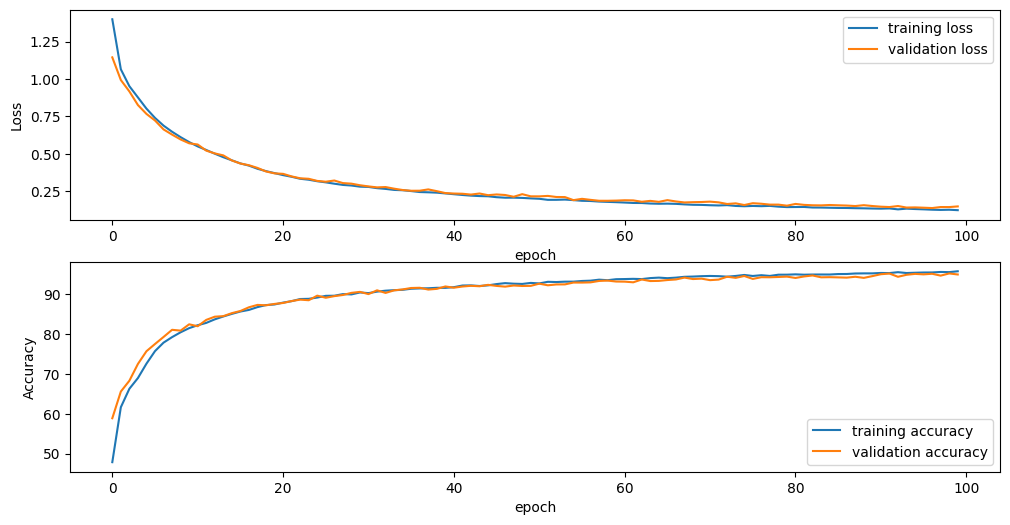

In [118]:
# Plot training and validation losses
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(train_loss_list,label='training loss')
plt.plot(val_loss_list,label='validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(train_accuracy_list,label='training accuracy')
plt.plot(val_accuracy_list,label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend();

## Evaluate Neural Network Model

Report the model's accuracy on the test set.

In [123]:
# report model accuracy on test data
model.eval()
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_loader):
        data = data.to(device).float()
        targets = targets.to(device)#.float()
        test_outputs = model(data)
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy += (predicted_test == targets).sum().item() / len(targets)

print('\ntest accuracy: ',(test_accuracy/len(test_loader))*100)

100%|██████████| 71/71 [00:00<00:00, 454.20it/s]


test accuracy:  95.54646960711638


Just for the sake of curiosity, let's take a random sample from the test set and see the model's prediction. So, randomly choose a sample from the test set and print it out (to see its features and also the correct output). Then, feed the features into your model and see what it predicts. Is it correct?

In [141]:
import random
# TODO: choose a random sample from test data and print it out

random_index = random.randint(0,test_df.shape[0]-1)
test_df.iloc[random_index:random_index+1]

,user_id,Day,origin,destination,start_time,end_time,price,Origin Lat,Origin Lon,Dest Lat,Dest Lon
4354,6,4,1,6,-1.416308,-1.341139,-0.386712,0.068394,1.449904,0.870527,0.978733


In [157]:
# TODO: predict the destination of the above sample
# print out the prediction

example = test_df.iloc[random_index:random_index+1].drop('destination',axis=1)
print(f'Predicted: {model(torch.tensor(example.values).cuda().float()).argmax()}')

Predicted: 6


In [162]:
# TODO: print out the actual destination of the above sample
print(f'Actual: {test_df["destination"].iloc[random_index:random_index+1].values[0]}')

Actual: 6


Now, use the inverse transform of the encoding you used earlier to get the name of the destination from the predicted class. Print it out and see if it's correct.

In [173]:
# TODO: use inverse_transform to print out the actual name of destination of the above sample

print(f'Name of predicted destination: {place_encoder.inverse_transform(test_df["destination"].iloc[random_index:random_index+1].values)[0]}')

Name of predicted destination: work


**QUESTION**: What do you think about this approach? Is it a good idea to use Neural Networks for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

**Your Answer:**

Clearly, the MLP classifier outperforms KNN and XGB on both the training and test datasets, demonstrating its superior ability to estimate the underlying patterns of the dataset compared to other models. Even if the patterns in our dataset, related to passengers' history, become more complex, the MLP model can still accurately classify the test dataset given that the training dataset is large enough.

# How to Submit:

Please upload your notebook (`.ipynb`) compressed (as a `.zip` file) or uncompressed on Quera. **Note** that for each part, the accuracy of your model on the given test dataset is important. So, your accuracy should be **at least** same as ours (or better). Also, we will check your code after the submission. So, please make sure that there are no **data snooping** or **data leakage** in your code. You **can not** use the test data in any stages for your model, except for the final evaluation part! So, please be ware of that, or you may lose points.

Your project is graded via 2 main parts:
1. Checking out your implementation (to check if there are no "data snooping" and "data leakage")
   
2. Checking accuracies of your models on the test set.

3. Running again your code by you in the "in-person" session and hearing your explanations (on the parts that we asked questions about the models, overfitting and etc. with tag "QUESTION" in the notebook).